# 

# Task02 - 数据读取与数据扩增

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as ud
from torchvision import transforms
from torchvision import datasets
from PIL import Image
import cv2
import glob
import json

## 模型数据准备，数据扩增

In [11]:
# 进行数据扩展

class SVHDataset(ud.Dataset):
    def __init__(self, img_pattern, label_folder, transform=None):
        self.img_path = glob.glob(img_pattern)
        self.img_label = [v['label'] for k,v in json.load(open(label_folder)).items()]
        self.img_path.sort()
        self.transform = transform
    def __getitem__(self, index):
        """
        实现了切片方法的获取
        """
        # 批量读取数据
        img = Image.open(self.img_path[index]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        # 将原始数据分类10为0, 保证有五位数字
        # example: [10]*2 = [10, 10], [2, 3] + [10] = [2, 3, 10]
        lbl = np.array(self.img_label[index], dtype=np.int)
        lbl = list(lbl) + (5 - len(lbl))*[10]
        return img, torch.Tensor(lbl[:5])
    def __len__(self):
        return len(self.img_path)

In [12]:
# 数据扩充和训练规范化
data_transforms = {
    'train': transforms.Compose([
                # 缩放到固定尺⼨
                transforms.Resize((64, 128)),
                transforms.RandomCrop((60, 120)),
                transforms.ColorJitter(0.3, 0.3, 0.2),
                # 加⼊随机旋转
                transforms.RandomRotation(10),
                # 将图⽚转换为pytorch 的tesntor
                transforms.ToTensor(),
                # 对图像像素进⾏归⼀化
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ]),
    'val': transforms.Compose([
                # 缩放到固定尺⼨
                transforms.Resize((60, 128)),
                # 将图⽚转换为pytorch 的tesntor
                transforms.ToTensor(),
                # 对图像像素进⾏归⼀化
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ]),
}

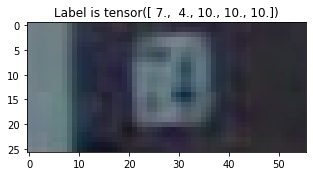

In [13]:
# 测试切片的方法
img_01, label_01 = SVHDataset('Datasets/mchar_train/*.png', 'Datasets/mchar_train.json')[np.random.choice(range(30000))]
plt.figure(figsize=(5, 5))
plt.title('Label is %s' % label_01)
plt.imshow(img_01)

In [18]:
import sys

EPOCH = 12
BATCH_SIZE = 30
USE_CUDA = True

train_loader = ud.DataLoader(
    dataset=SVHDataset('Datasets/mchar_train/*.png', 'Datasets/mchar_train.json', data_transforms['train']),
    batch_size=BATCH_SIZE,
    shuffle=True,
    # num_workers 在windows上报错 设置改为 0
    num_workers= (0 if sys.platform.startswith('win') else 10)
)
val_loader = ud.DataLoader(
    dataset=SVHDataset('Datasets/mchar_val/*.png', 'Datasets/mchar_val.json', data_transforms['val']),
    batch_size=BATCH_SIZE,
    shuffle=False,
    # num_workers 在windows上报错 设置改为 0
    num_workers= (0 if sys.platform.startswith('win') else 10)
)

## 模型结构定义

In [19]:
from torchvision import models

# 初始化构建线性网络
class SVHN_Model(torch.nn.Module):
    def __init__(self, path=None):
        super(SVHN_Model, self).__init__()
        if path is None:
            model_conv = models.resnet18(pretrained=True)
        else:
            model_conv = models.resnet18(pretrained=False)
            model_conv.load_state_dict(torch.load(path))
        model_conv.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        model_conv = torch.nn.Sequential(*list(model_conv.children())[:-1])
        self.cnn = model_conv
        # 每个字符有11中情况
        self.fc1 = torch.nn.Linear(512, 11)
        self.fc2 = torch.nn.Linear(512, 11)
        self.fc3 = torch.nn.Linear(512, 11)
        self.fc4 = torch.nn.Linear(512, 11)
        self.fc5 = torch.nn.Linear(512, 11)
    def forward(self, img):
        # activation function for
        # 容易过拟合导致准确度下降
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)
        feat = F.dropout2d(feat)
        # 排除其他无关元素影响，只留正相关因素
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        c5 = self.fc5(feat)
        return c1, c2, c3, c4, c5

## 验证、训练、预测方法定义

In [20]:
from functools import reduce

def train_def(train_loader, model, loss_func, optimizer):
    
    # 切换模型为训练模式
    model.train()
    train_loss = []

    for step, (batch_x, batch_y) in enumerate(train_loader):
        # train your data...
        if USE_CUDA:
            batch_x = batch_x.cuda()
            # 将 float32 强制转换为 long
            batch_y = batch_y.long().cuda()
        predicate = model(batch_x)
        # 对应个位置上的字符 -> [11情况概率] <=> [label真实值]
        loss = reduce(lambda x, y: x + y, [loss_func(predicate[m], batch_y[:, m]) for m in range(batch_y.shape[1])])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    return np.array(train_loss)
        
def validate_def(val_loader, model, loss_func):
    # 切换模型为预测模型
    model.eval()
    val_loss = []
    # 不记录模型梯度信息
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(val_loader):
            if USE_CUDA:
                batch_x = batch_x.cuda()
                # 将 float32 强制转换为 long
                batch_y = batch_y.long().cuda()
            predicate = model(batch_x)
            # 叠加 loss_func
            loss = reduce(lambda x, y: x + y, [loss_func(predicate[m], batch_y[:, m]) for m in range(batch_y.shape[1])])
            val_loss.append(loss.item())
    return np.array(val_loss)

def predict_def(test_loader, model, tta=10):
    
    model.eval()
    test_pred_tta, test_target_tta = None, None

    # TTA 次数
    for _ in range(tta):
        test_pred, test_target = [], []
        with torch.no_grad():
            for step, (batch_x, batch_y) in enumerate(test_loader):
                if USE_CUDA:
                    batch_x = batch_x.cuda()
                    batch_y = batch_y.long().cuda()
                predicate_y = model(batch_x)
                output = torch.stack(predicate_y, dim=1)
                # 最大概率的索引值
                output = torch.argmax(output, dim=2)
                test_pred.append(output)
                test_target.append(batch_y)
                
        test_pred, test_target = torch.cat(test_pred), torch.cat(test_target)
        
        if test_pred_tta is None:
            test_pred_tta, test_target_tta = test_pred, test_target
        else:
            test_pred_tta += test_pred
            test_target_tta += test_target
    return test_pred_tta, test_target_tta

## 模型执行

In [21]:
model = SVHN_Model()  # define the network
if USE_CUDA:
    model = model.cuda()

# 开启训练模式

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
# the target label is NOT an one-hotted
loss_func = torch.nn.CrossEntropyLoss()

best_loss = 15

train_loss_list = []
val_loss_list = []
val_char_acc_list = []

for epoch in range(EPOCH):
    
    # 损失得分
    train_loss = train_def(train_loader, model, loss_func, optimizer)
    val_loss = validate_def(val_loader, model, loss_func)
    
    # 预测值结果与真实值比较关联
    val_predict_label, val_target_label = predict_def(val_loader, model, 1)
    val_label_pred = np.array([''.join(map(lambda x: str(x.item()), labels[labels!=10])) for labels in val_predict_label])
    val_label_target = np.array([''.join(map(lambda x: str(x.item()), labels[labels!=10])) for labels in val_target_label])
    
    # score 评价得分
    val_char_acc = np.sum(val_label_pred == val_label_target) / len(val_label_target)
    
    #将值添加到list
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_char_acc_list.append(val_char_acc)
    
    print('Epoch: {0}, Train loss: {1} \t Val loss: {2}'.format(epoch, np.mean(train_loss), np.mean(val_loss)))
    print('Val Acc', val_char_acc)
    
    # 记录下验证集最佳精度
    if np.mean(val_loss) < best_loss:
        best_loss = np.mean(val_loss)
        print('Find better model in Epoch {0}, saving model.'.format(epoch))
        # 保存模型参数
        torch.save(model.state_dict(), './model.pt')

Epoch: 0, Train loss: 4.089868594169617 	 Val loss: 3.9160617254451364
Val Acc 0.2844
Find better model in Epoch 0, saving model.
Epoch: 1, Train loss: 2.6186632356643678 	 Val loss: 3.4281392861269193
Val Acc 0.3556
Find better model in Epoch 1, saving model.
Epoch: 2, Train loss: 2.157112566769123 	 Val loss: 3.021617318341832
Val Acc 0.4372
Find better model in Epoch 2, saving model.
Epoch: 3, Train loss: 1.9390207701325417 	 Val loss: 2.865516772527181
Val Acc 0.4605
Find better model in Epoch 3, saving model.
Epoch: 4, Train loss: 1.7700363944172859 	 Val loss: 2.7528493647089975
Val Acc 0.4898
Find better model in Epoch 4, saving model.
Epoch: 5, Train loss: 1.6435419206023216 	 Val loss: 2.58240013565132
Val Acc 0.5245
Find better model in Epoch 5, saving model.
Epoch: 6, Train loss: 1.5447513986825943 	 Val loss: 2.7017596945791187
Val Acc 0.5033
Epoch: 7, Train loss: 1.4533139135539532 	 Val loss: 2.4495439599017184
Val Acc 0.5428
Find better model in Epoch 7, saving model.
Ep

(12000,)


Text(0.5, 1.0, 'Val Accuracy from epoch')

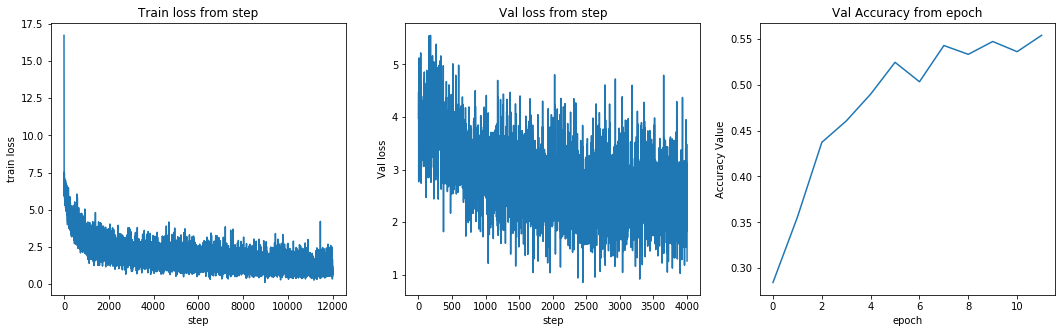

In [22]:
import seaborn as sns
sns.set_style()
train_loss = np.hstack(np.array(train_loss_list))
print(train_loss.shape)
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(train_loss)
plt.xlabel('step')
plt.ylabel('train loss')
plt.title('Train loss from step')
plt.subplot(1, 3, 2)
val_loss = np.hstack(np.array(val_loss_list))
plt.plot(val_loss)
plt.xlabel('step')
plt.ylabel('Val loss')
plt.title('Val loss from step')
plt.subplot(1, 3, 3)
plt.plot(val_char_acc_list)
plt.xlabel('epoch')
plt.ylabel('Accuracy Value')
plt.title('Val Accuracy from epoch')